# Notes on the paper `The Curious Case of Neural Text Degeneration`, 
Holtzman et al., ICLR 2020

## The goal of these notes is to understand the major `decoding strategies` introduced in the paper.

## Introduction: a `top-down` strategy for reading a paper

#### Step 1: Read the abstract, then skip to the conclusion and read it. 
#### SStep 2: closely examine all the tables and figures, understand as much as you can about them. 
#### SStep 3: skim the paper once through and note down unfamiliar terms and ideas that need to be learned. 
#### SStep 4: read the paper with attention, filling in the gaps in your runderstanding of the figures and key terms.

Here is a list of the key terms in this paper:
* Decoding strategy
* Self-BLEU
* Perplexity
* Zipf's Law
* Beam Search
* Temperature Sampling
* Pure Sampling
* Top-k sampling
* Nucleus, or top-p sampling
* Stochastic Beam Search

## 1. Decoding Strategies

#### In the context of a language model, suppose we are given a sequence of words $(x_{1}, x_{2}, ...,x_{i-1})$ and our goal is to predict the next word $x_{i}$. Suppose further that we have narrowed down our choices to a set of words $V$, and that we have an RNN (recurrrent neural network) whose outputs $u_{1:|V|}$ are the `activations` for choosing each word in the vocabulary $V$. Here $|V|$ is the cardinality of $V$, the number of words in the vocabulary.   To predict the next word, we need the `conditional probabilities` for all the words in the vocabulary.  Once we have the` conditional probabilities we can apply a `decoding strategy` to choose the next word

#### Here are some of the `decoding strategies` considered in the paper: 
* `Greedy search`: choose the most probable word
* `Pure sampling`: randomly sample from the probability distribution of the entire vocabulary
In `pure sampling`, the likelihood of selecting a word is proportional to its conditional probability, so that words with the highest probabilities are more likely to be selected. Note that this is not the same as choosing a word from the vocabulary at random.
* For `top-k search`, we randomly sample from the $k$ most probable words, at each step. Note that for $k=1$, this `greedy search`, and for $k = |V|$ it's `pure sampling`.
* For `nucleus search` or `top-p` sampling, we sample from the probability distribution of the minimum number $k$ of most probable words whose summed probabilities exceed a threshold, say $p=0.95$. This set of $k$ words is called the `nucleus`, and the number $k$ will usually change at each step. Again, if $p=1$ this is just `pure sampling`, and if $p=0$ it's `greedy search`
* `Beam search`: we build trees from the $b$ most probable words, where $b$ is called the `beam width`. We build each tree by considering $b$ possibilities at each split, until we reach either a maximum number of tokens, or an `end of sentence` token. Then we select the word associated with the tree that had maximum probability. Note that with `beam width` of 1, `beam search` becomes `greedy search`. Listen to `Andrew Ng` explain `beam search` in his own inimitable style in under $12$ minutes: https://www.youtube.com/watch?v=RLWuzLLSIgw 
* Temperature Sampling, to be explained below.

As we saw, the paper provides an excellent discussion of the advantages and disadvantages of these decoding strategies in text generation. The main disadvantages found in many of these strategies are repetition, lack of diversity, and divergence from human-generated word sequencing structure (Zipf's Law). They showed that their new `nucleus search` strategy performed quite well on important metrics that are used to assess machine translation and text generation.







## 2. What is `Temperature`?

#### Let's return for a moment to the `conditional probabilities` for the words in $V$. How do we compute them from the activation outputs outputs $𝑢_{1:|𝑉|}$? Normally, we would  applying the `softmax` to the activations like so: 

### $ p(x_{n+1} = V_k | x_{1}, x_{2}, ...,x_{n} ) = \frac{exp(u_k)}{\sum_{j=1}^{|V|}exp(u_j)}$

#### The paper introduced an alternative method of setting the `conditional probabilities`. It works like this:

#### Select a `temperature` parameter $T$ with a value  $0 < T <  \infty$. Modify the `softmax` as follows:

### $ p(x_{n+1} = V_k | x_{1}, x_{2}, ...,x_{n} ) = \frac{exp(u_k/T)}{\sum_{j=1}^{|V|}exp(u_j/T)}$
#### Note that the only difference from the `softmax` is that the activations are scaled by a factor of $\frac{1}{T}$


## 3. How does Temperature Sampling work?

#### Modifying the softmax with a temperature alters the distribution of word probabilities. But how the distribution changes is beyond my intuition. So let's do a simulation to see if we can gain insight into this question!

 #### Suppose we have 10 words with activations chosen to make the word probabilities linear, just for this example

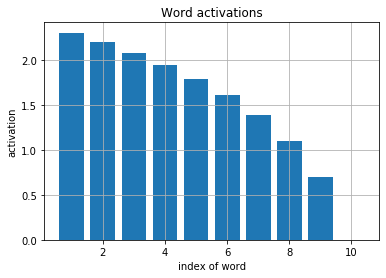

In [65]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# activations
activations = np.log(11*np.ones(10)  -np.linspace(1,10,10))

fig, ax = plt.subplots()
plt.bar(np.linspace(1,10,10), activations)
plt.xlabel('index of word')
plt.ylabel('activation')
plt.title('Word activations')
plt.grid()
plt.show()


### Function to plot probabilites at different temperatures
Here we implement the formula from section 2 above

In [67]:
def plot_probs(activations,T=1):
    probs = np.exp(activations/T)/sum(np.exp(activations/T))
    fig, ax = plt.subplots()
    plt.bar(np.linspace(1,len(probs),10), probs)
    plt.xlabel('index of word')
    plt.ylabel('probability')
    plt.title('Word Probabilities')
    if(T!=1):
        plt.legend(['Temperature = '+str(T)])
    plt.grid()
    plt.show()

## Word probabilities (no temperature effect, i.e. T = 1)

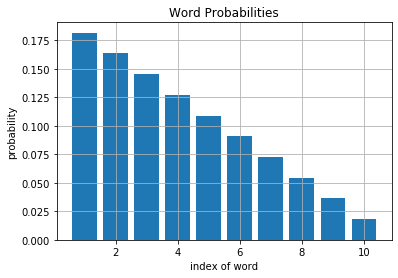

In [68]:
plot_probs(activations,T = 1)

## Let's see how changing the temperature affects the word probability distribution 

## T = 0.2

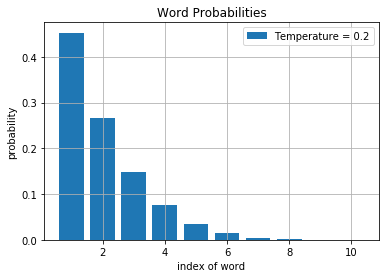

In [57]:
plot_probs(activations,T = 0.2)

## T = 0.5

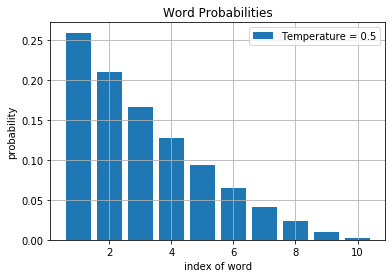

In [58]:
plot_probs(activations,T = 0.5)

### T = 0.7

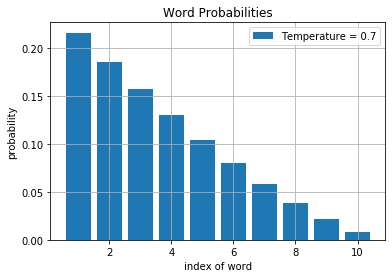

In [59]:
plot_probs(activations,T = 0.7)

### T = 2

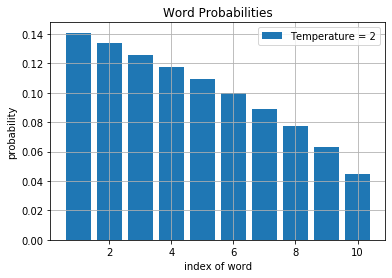

In [64]:
plot_probs(activations,T = 2)

### T = 5

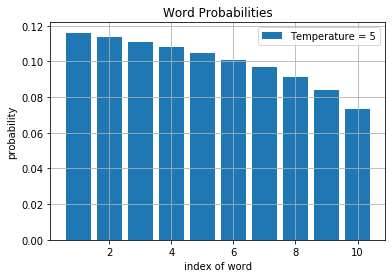

In [60]:
plot_probs(activations,T = 5)

### T = 10

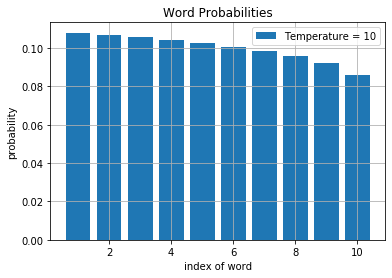

In [61]:
 # Choose a Temperature compute new probs
plot_probs(activations,T = 10)

## Observations
We see that 
* increasing the temperature above 1 pushes stretches the probability to the right, plumping up the 'tail'
* decreasing the temperature below 1 (still keeping it positive) squeezes the probability to the left so that it peaks more sharply near word 1.  
